### Gathering the data from the tables stored on snowflake

In [16]:
import snowflake.connector
import pandas as pd

# Credenciais Snowflake
SF_USER = "DAVISIQUEIRA"
SF_PASSWORD = "TrFHv.bEB.u8Seg"
SF_ACCOUNT = "PAILQHF-SD40239"
SF_WAREHOUSE = "COMPUTE_WH"
SF_DATABASE = "MEU_DB"
SF_SCHEMA = "PUBLIC"

# Conexão
conn = snowflake.connector.connect(
    user=SF_USER,
    password=SF_PASSWORD,
    account=SF_ACCOUNT,
    warehouse=SF_WAREHOUSE,
    database=SF_DATABASE,
    schema=SF_SCHEMA
)

# Consulta clientes
query = "SELECT * FROM customers_refined LIMIT 1000"
df = pd.read_sql(query, conn)

# Consulta pedidos
query_orders = "SELECT * FROM ORDERS_REFINED LIMIT 1000"
df_orders = pd.read_sql(query_orders, conn)

# Ajusta nomes de colunas para minúsculas
df_orders.columns = df_orders.columns.str.lower()

import pandas as pd

def safe_timestamp_to_datetime(series):
    # Converte para int, ignora erros
    series = pd.to_numeric(series, errors='coerce')
    
    # Remove valores nulos (ou você pode decidir como tratá-los)
    series = series.dropna().astype('int64')
    
    # Detecta unidade: se muito grande, assume ns; se médio, ms; senão, s
    max_val = series.max()
    
    if max_val > 1e18:           # Provavelmente nanosegundos
        unit = 'ns'
    elif max_val > 1e12:         # Provavelmente milissegundos
        unit = 'ms'
    else:                        # Provavelmente segundos
        unit = 's'
    
    return pd.to_datetime(series, unit=unit)

# Aplicando ao seu dataframe
if 'order_purchase_timestamp' in df_orders.columns:
    df_orders['order_purchase_datetime'] = safe_timestamp_to_datetime(df_orders['order_purchase_timestamp'])

print(df_orders.head())

# Fecha conexão
conn.close()

# Mostra as primeiras linhas de clientes (opcional)
# print(df.head())
# df.info()
# df.describe()


C:\Users\pacie\AppData\Local\Temp\ipykernel_10008\3194093317.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
C:\Users\pacie\AppData\Local\Temp\ipykernel_10008\3194093317.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_orders = pd.read_sql(query_orders, conn)


                           order_id                       customer_id  \
0  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
1  85ce859fd6dc634de8d2f1e290444043  059f7fc5719c7da6cbafe370971a8d70   
2  6ea2f835b4556291ffdc53fa0b3b95e8  c7340080e394356141681bd4c9b8fe31   
3  68873cf91053cd11e6b49a766db5af1a  4632eb5a8f175f6fe020520ae0c678f3   
4  8f06cc6465925031568537b815f1198d  9916715c2ab6ee1710c9c32f0a534ad2   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      1511033286000000000  1511034359000000000   
1    delivered      1511222621000000000  1511223262000000000   
2    delivered      1511558868000000000  1511569269000000000   
3    delivered      1512079335000000000  1512183078000000000   
4    delivered      1510745501000000000  1510746402000000000   

  order_delivered_carrier_date order_delivered_customer_date  \
0          1511357999000000000           1512174522000000000   
1          1511472746000000000           1511807

### Analise univariada de customers_refined

Variáveis numéricas: []
Variáveis categóricas: ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'customer_city_clean']


C:\Users\pacie\AppData\Local\Temp\ipykernel_10008\1604906087.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_zips.values, y=top_zips.index, palette="coolwarm")


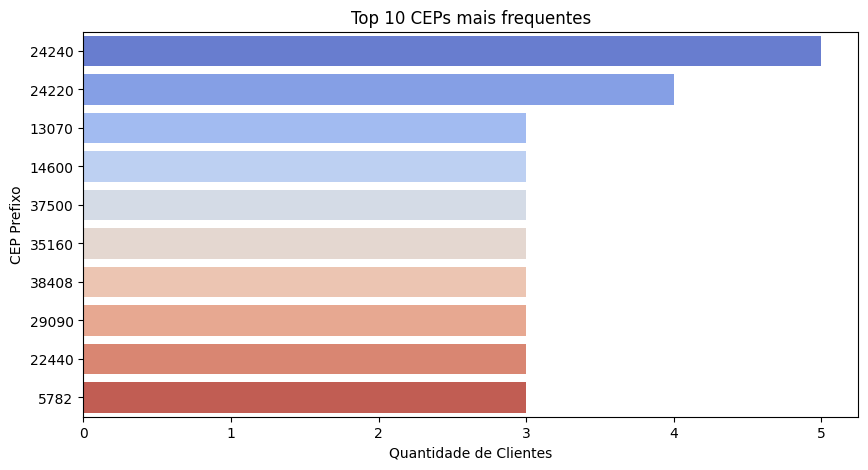

C:\Users\pacie\AppData\Local\Temp\ipykernel_10008\1604906087.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cities.values, y=top_cities.index, palette="viridis")


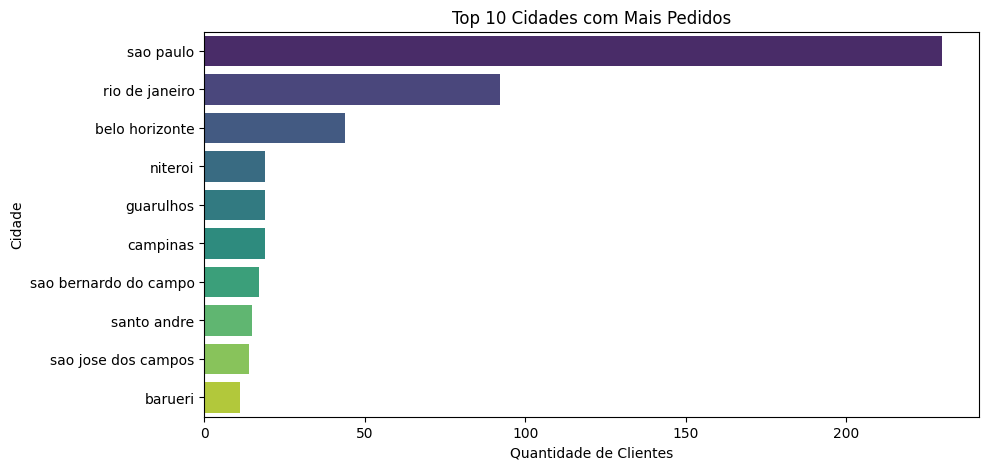

C:\Users\pacie\AppData\Local\Temp\ipykernel_10008\1604906087.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_states.values, y=top_states.index, palette="magma")


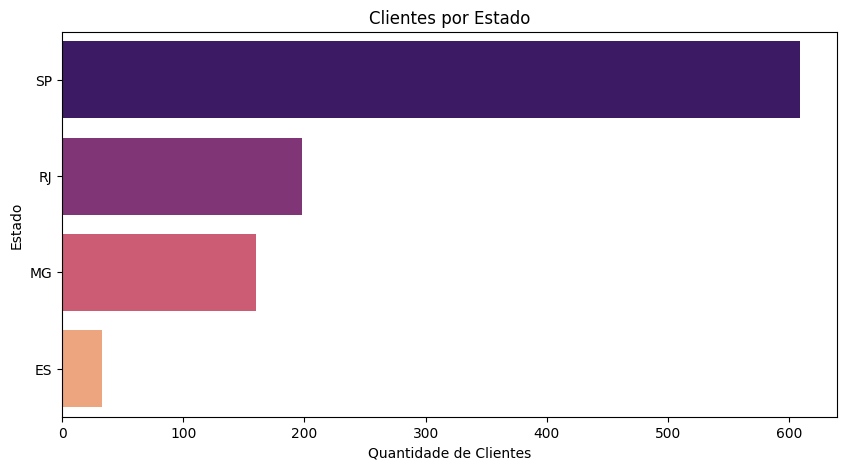


📊 Proporção de clientes por estado:
Estado  Clientes Percentual (%)
    SP       609          60.90
    RJ       198          19.80
    MG       160          16.00
    ES        33           3.30


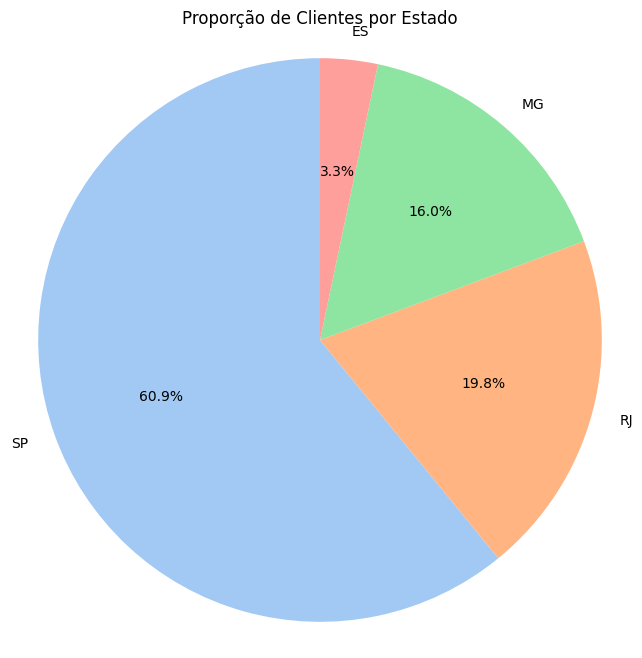

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# ============================
# Separar variáveis numéricas e categóricas
# ============================
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# Se o zip code estiver como numérico, tratamos como string
if 'customer_zip_code_prefix' in num_cols:
    df['customer_zip_code_prefix'] = df['customer_zip_code_prefix'].astype(str)
    num_cols.remove('customer_zip_code_prefix')
    cat_cols.append('customer_zip_code_prefix')

print("Variáveis numéricas:", num_cols)
print("Variáveis categóricas:", cat_cols)

# ============================
# 1. Análise univariada - Zip Code Prefix (agora categórico)
# ============================
if 'customer_zip_code_prefix' in cat_cols:
    top_zips = df['customer_zip_code_prefix'].value_counts().head(10)
    plt.figure(figsize=(10,5))
    sns.barplot(x=top_zips.values, y=top_zips.index, palette="coolwarm")
    plt.title("Top 10 CEPs mais frequentes")
    plt.xlabel("Quantidade de Clientes")
    plt.ylabel("CEP Prefixo")
    plt.show()

# ============================
# 2. Análise univariada - Cidades
# ============================
if 'customer_city' in cat_cols:
    top_cities = df['customer_city'].value_counts().head(10)
    plt.figure(figsize=(10,5))
    sns.barplot(x=top_cities.values, y=top_cities.index, palette="viridis")
    plt.title("Top 10 Cidades com Mais Pedidos")
    plt.xlabel("Quantidade de Clientes")
    plt.ylabel("Cidade")
    plt.show()

# ============================
# 3. Análise univariada - Estados
# ============================
if 'customer_state' in cat_cols:
    top_states = df['customer_state'].value_counts()
    plt.figure(figsize=(10,5))
    sns.barplot(x=top_states.values, y=top_states.index, palette="magma")
    plt.title("Clientes por Estado")
    plt.xlabel("Quantidade de Clientes")
    plt.ylabel("Estado")
    plt.show()


# ============================
# 4. Proporção de clientes por estado
# ============================
if 'customer_state' in cat_cols:
    state_counts = df['customer_state'].value_counts()
    state_percent = (state_counts / state_counts.sum()) * 100

    # DataFrame para visualização
    state_df = pd.DataFrame({
        'Estado': state_counts.index,
        'Clientes': state_counts.values,
        'Percentual (%)': state_percent.values
    })

    # Ordenar por percentual
    state_df = state_df.sort_values(by='Percentual (%)', ascending=False)

    # Exibir tabela
    print("\n📊 Proporção de clientes por estado:")
    print(state_df.to_string(index=False, formatters={'Percentual (%)': '{:.2f}'.format}))

    # Gráfico de pizza
    plt.figure(figsize=(8,8))
    plt.pie(
        state_df['Clientes'],
        labels=state_df['Estado'],
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette("pastel", len(state_df))
    )
    plt.title("Proporção de Clientes por Estado")
    plt.axis('equal')  # garante que o gráfico seja um círculo
    plt.show()


### Analise univariada de Orders_refined

In [17]:
# Separar variáveis numéricas e categóricas
num_cols = df_orders.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df_orders.select_dtypes(include=['object']).columns.tolist()

# Se tiver timestamps convertidos para datetime, removemos de numéricas
if 'order_purchase_datetime' in num_cols:
    num_cols.remove('order_purchase_datetime')

# Visualizar colunas
print("Variáveis numéricas:", num_cols)
print("Variáveis categóricas:", cat_cols)


Variáveis numéricas: []
Variáveis categóricas: ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'approval_time_hours', 'processing_time_hours', 'shipping_time_hours', 'total_delivery_time_hours', 'delivery_delay_hours', 'delivery_performance', 'purchase_hour', 'purchase_day_of_week']


C:\Users\pacie\AppData\Local\Temp\ipykernel_10008\2036265061.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette="coolwarm")


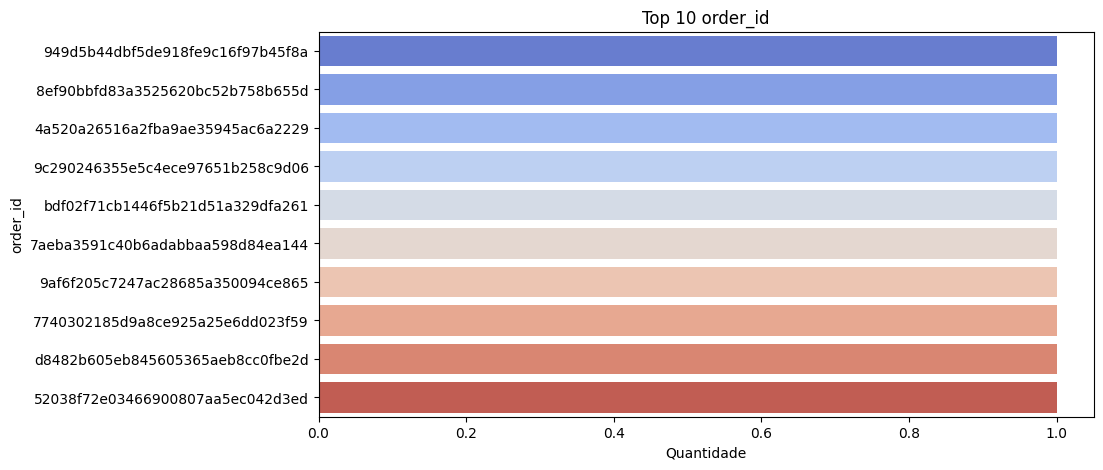

C:\Users\pacie\AppData\Local\Temp\ipykernel_10008\2036265061.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette="coolwarm")


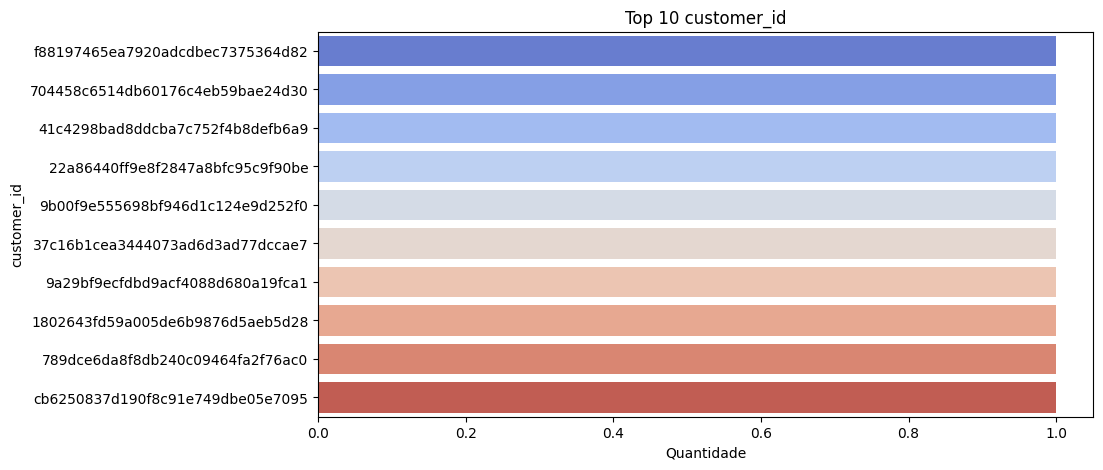

C:\Users\pacie\AppData\Local\Temp\ipykernel_10008\2036265061.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette="coolwarm")


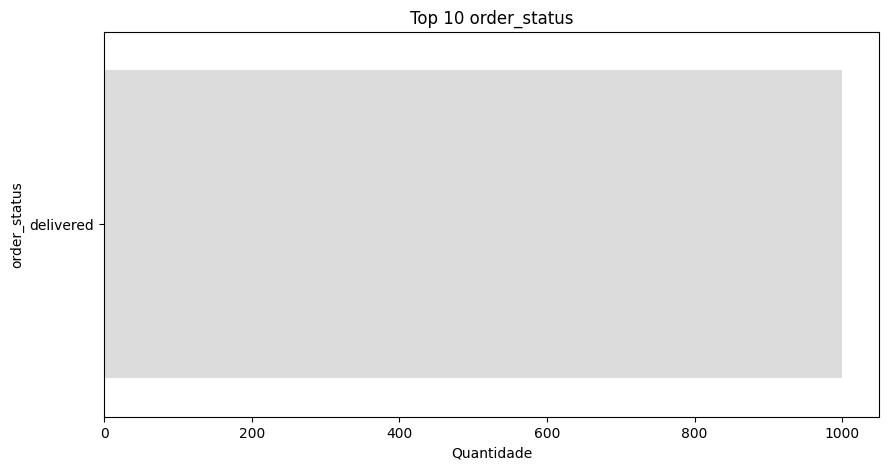

C:\Users\pacie\AppData\Local\Temp\ipykernel_10008\2036265061.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette="coolwarm")


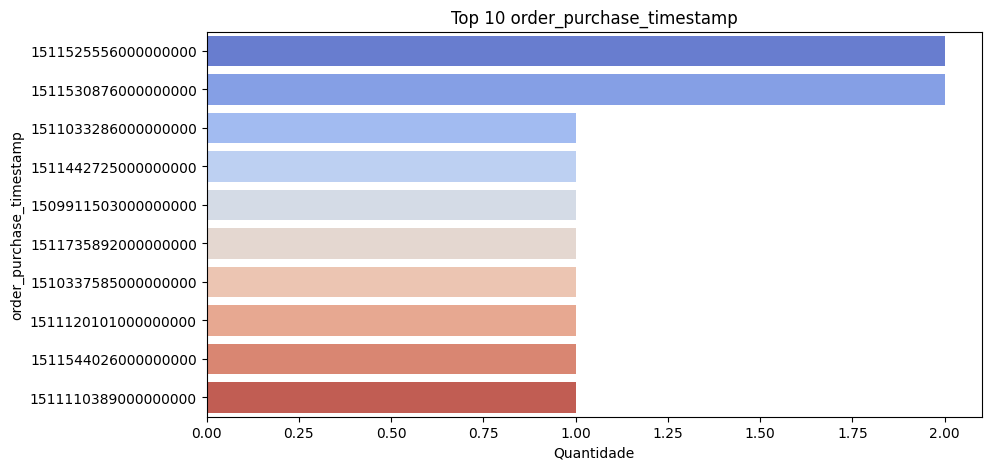

C:\Users\pacie\AppData\Local\Temp\ipykernel_10008\2036265061.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette="coolwarm")


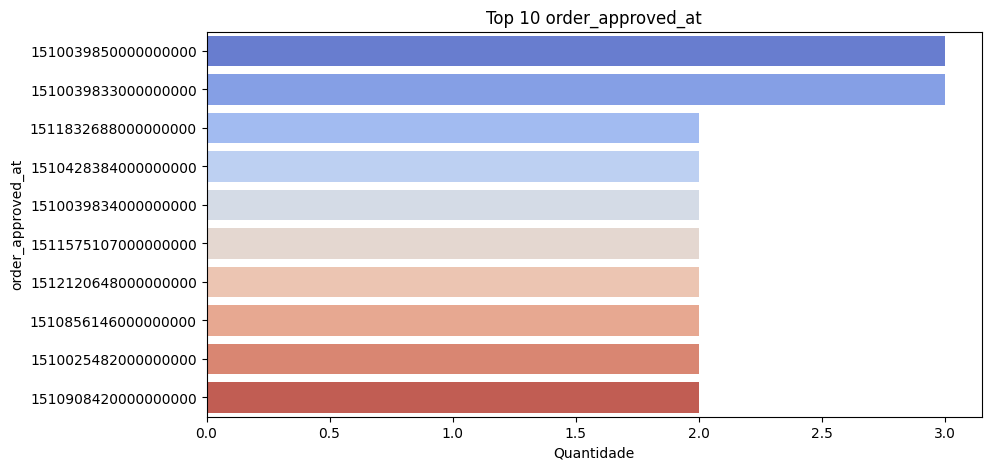

C:\Users\pacie\AppData\Local\Temp\ipykernel_10008\2036265061.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette="coolwarm")


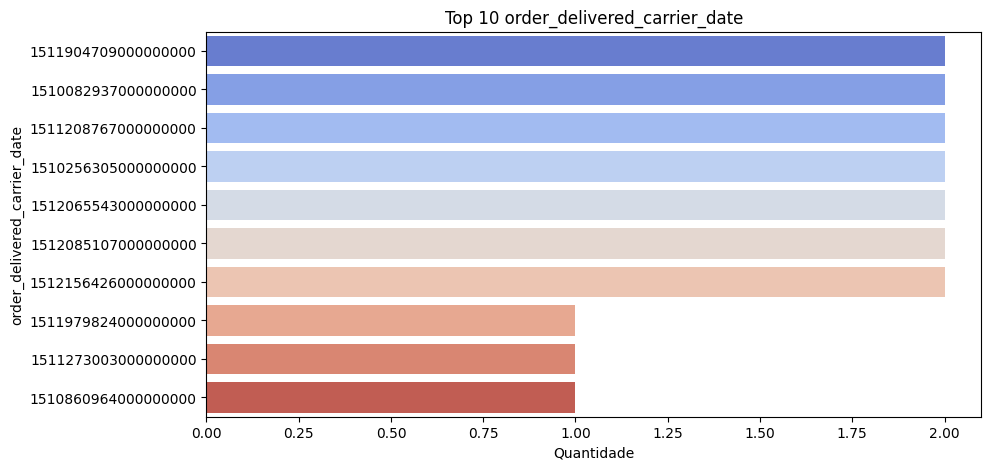

C:\Users\pacie\AppData\Local\Temp\ipykernel_10008\2036265061.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette="coolwarm")


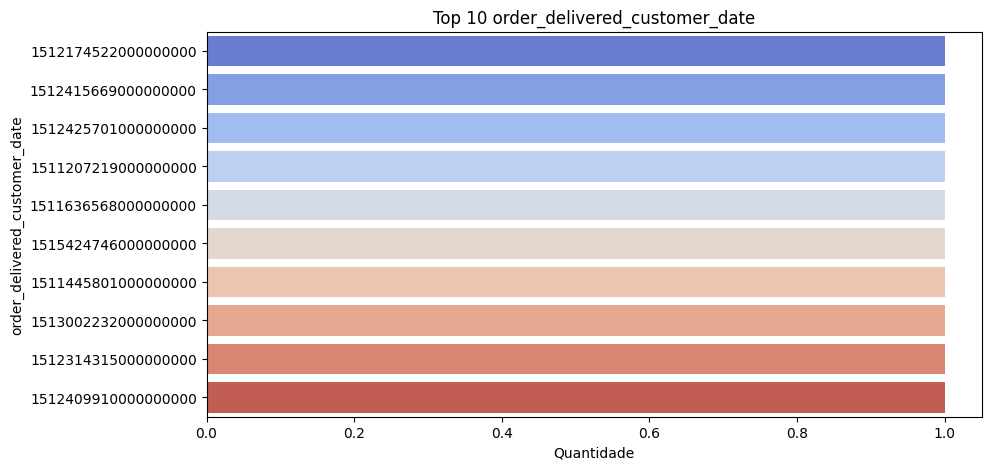

C:\Users\pacie\AppData\Local\Temp\ipykernel_10008\2036265061.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette="coolwarm")


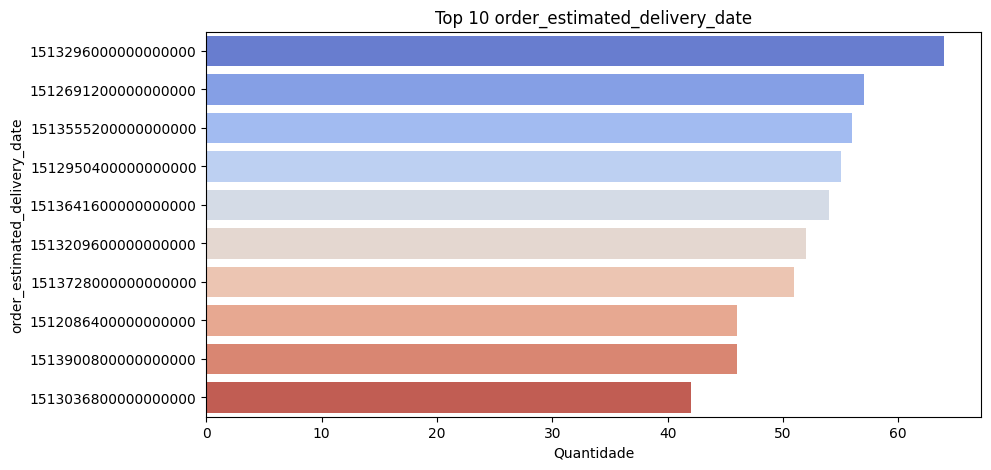

C:\Users\pacie\AppData\Local\Temp\ipykernel_10008\2036265061.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette="coolwarm")


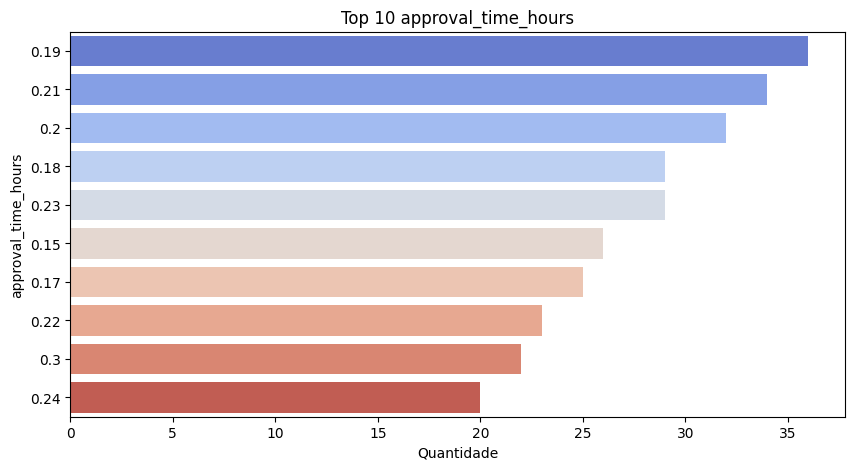

C:\Users\pacie\AppData\Local\Temp\ipykernel_10008\2036265061.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette="coolwarm")


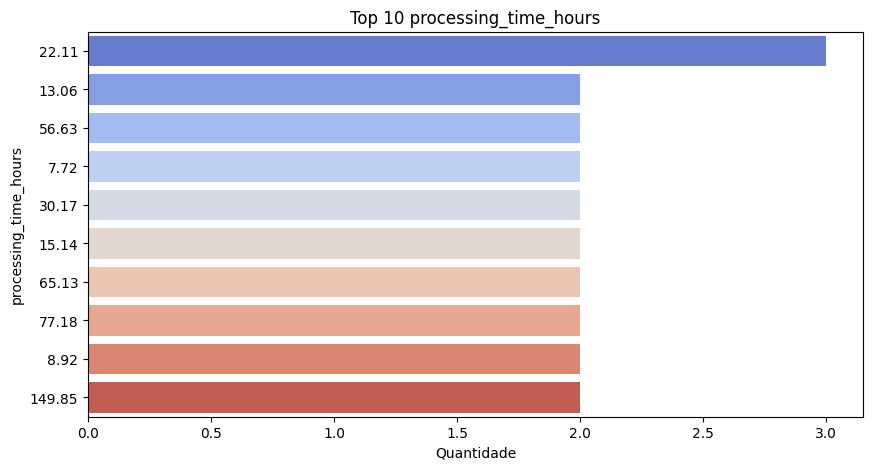

C:\Users\pacie\AppData\Local\Temp\ipykernel_10008\2036265061.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette="coolwarm")


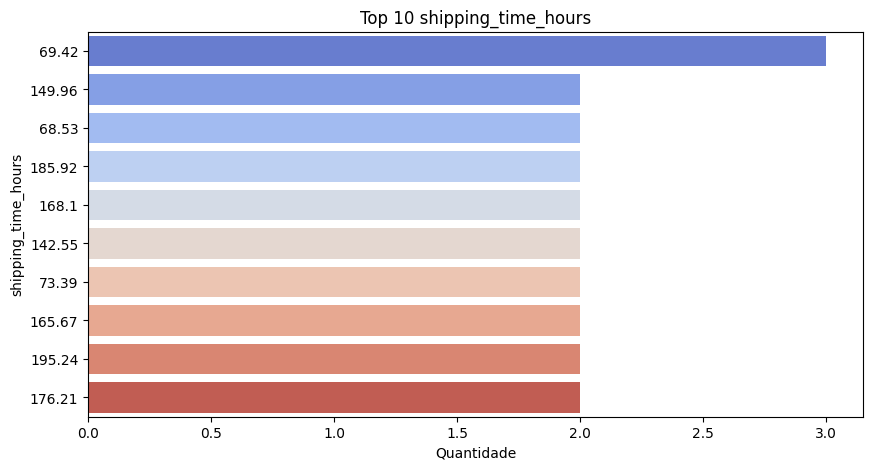

C:\Users\pacie\AppData\Local\Temp\ipykernel_10008\2036265061.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette="coolwarm")


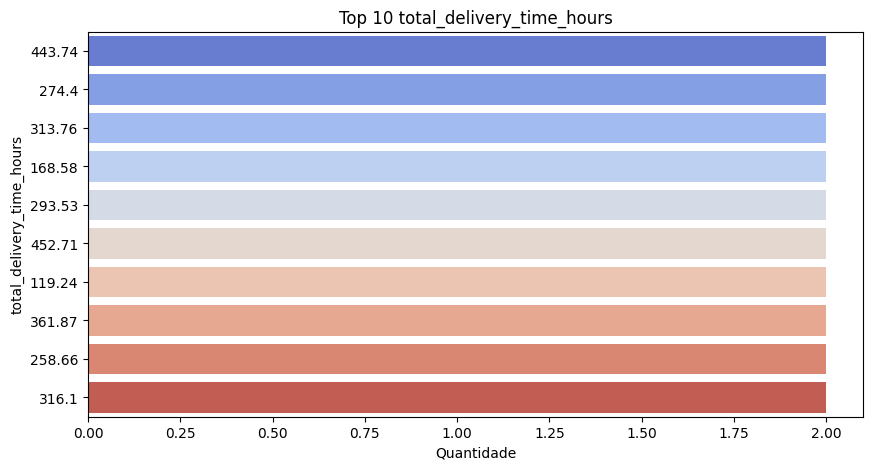

C:\Users\pacie\AppData\Local\Temp\ipykernel_10008\2036265061.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette="coolwarm")


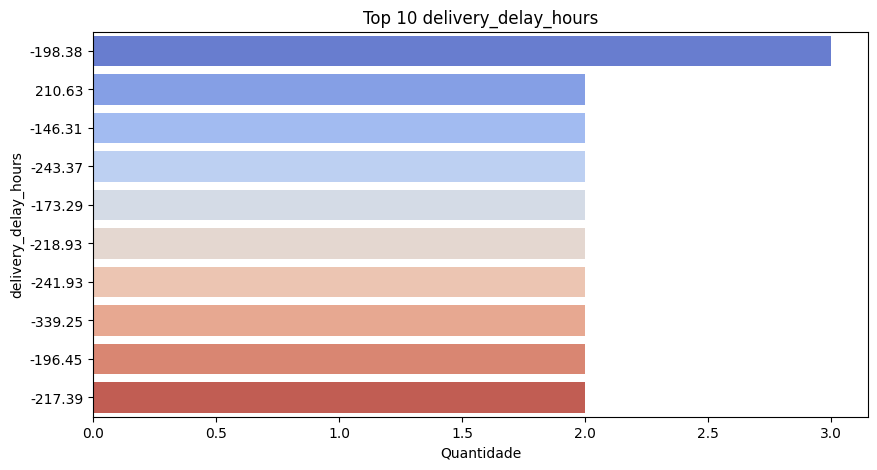

C:\Users\pacie\AppData\Local\Temp\ipykernel_10008\2036265061.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette="coolwarm")


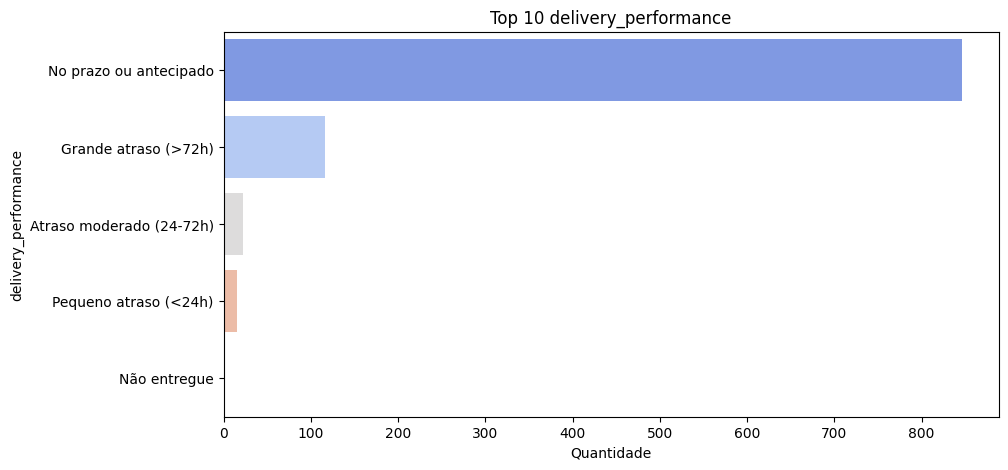

C:\Users\pacie\AppData\Local\Temp\ipykernel_10008\2036265061.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette="coolwarm")


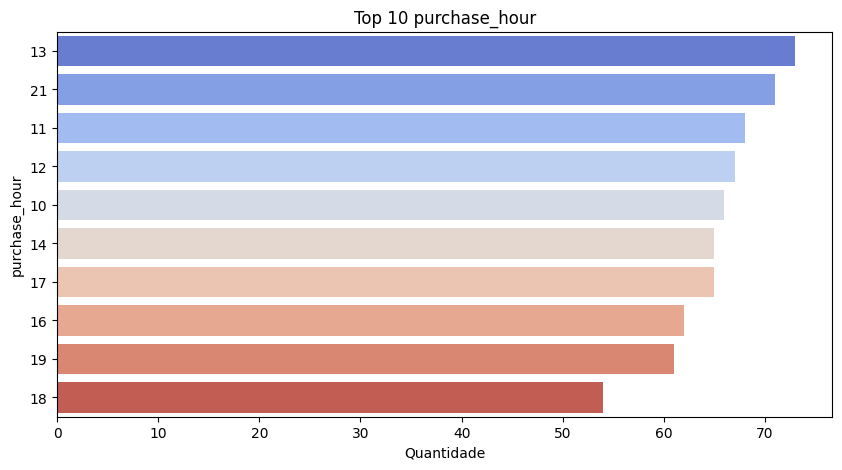

C:\Users\pacie\AppData\Local\Temp\ipykernel_10008\2036265061.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values.values, y=top_values.index, palette="coolwarm")


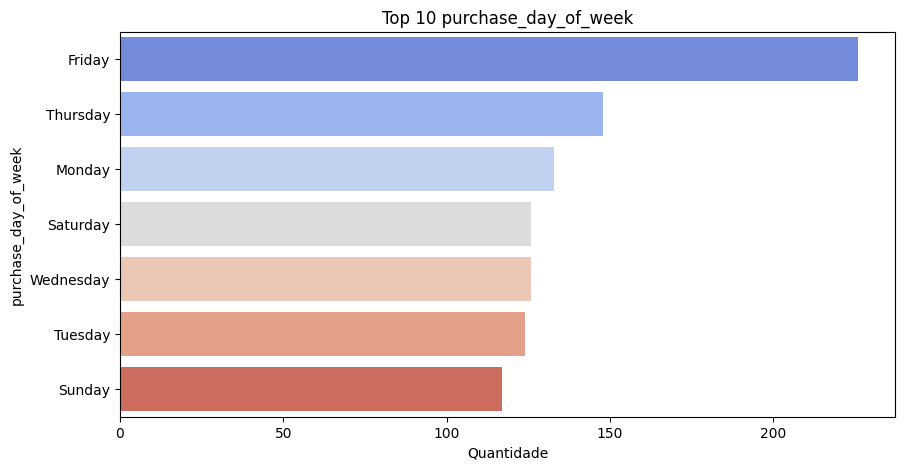

In [18]:
# numericas e categoricas

import matplotlib.pyplot as plt
import seaborn as sns

for col in num_cols:
    plt.figure(figsize=(10,4))
    sns.histplot(df_orders[col], kde=True, bins=30)
    plt.title(f'Distribuição de {col}')
    plt.show()

for col in cat_cols:
    top_values = df_orders[col].value_counts().head(10)
    plt.figure(figsize=(10,5))
    sns.barplot(x=top_values.values, y=top_values.index, palette="coolwarm")
    plt.title(f"Top 10 {col}")
    plt.xlabel("Quantidade")
    plt.ylabel(col)
    plt.show()
